In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Read the data

In [5]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Check our data, that we haven't nulls

In [6]:
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(0, 0)

In [7]:
train_data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

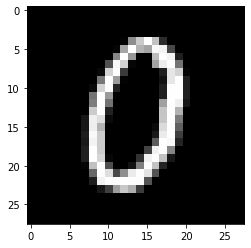

In [8]:
five = train_data.iloc[5, 1:]
five.shape
five = five.values.reshape(28, 28)
plt.imshow(five, cmap='gray')

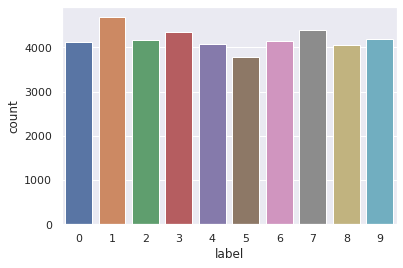

In [9]:
plt.ioff()
sns.set_theme(style="darkgrid")
ax = sns.countplot(data=train_data, x="label")

In [10]:
X = train_data.drop(["label"], axis=1)
y = train_data["label"]

In [11]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [12]:
class Sigmoid:
    def __call__(self, z):
        """
        Compute the sigmoid of z

        Arguments:
        z -- scalar or numpy array of any size.

        Return:
        sigmoid(z)
        """
        self.sigm = 1/(1+np.exp(-z))
        return self.sigm
    
    def prime(self, z):
        """
        Compute the derivative of sigmoid of z

        Arguments:
        z -- scalar or numpy array of any size.

        Return:
        Sigmoid prime
        """
        s = Sigmoid()(z)
        p = s * (1-s)
        return p


In [13]:
def one_hot(Y, n_classes):
    """
    Encode labels into a one-hot representation

    Arguments:
    Y -- array of input labels of shape (1, n_samples)
    n_classes -- number of classes

    Returns:
    onehot, a matrix of labels by samples. For each column, the ith index will be 
        "hot", or 1, to represent that index being the label; shape - (n_classes, n_samples)
    """
    b = np.zeros((n_classes, Y.size))
    b[Y, np.arange(Y.size)] = 1
    return b

In [14]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (4)
    
    Arguments:
    A2 -- sigmoid output of the hidden layer activation, of shape (classes, n_examples)
    Y -- labels of shape (classes, n_examples)
    
    Returns:
    cost -- cross-entropy cost given equation (4)
    """
    
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    cost = -1/m * np.sum(np.sum(Y*np.log(A2) + (1-Y)*np.log(1-A2)))
    
    return cost

In [15]:
class Regularization:
    """ 
    Regularization class

    Arguments:
    lambda_1 -- regularization coeficient for l1 regularization
    lambda_2 -- regularization coeficient for l2 regularization
    """
    def __init__(self, lambda_1, lambda_2):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        
    def l1(self, W1, W2, m):
        """ 
        Compute l1 regularization part

        Arguments:
        W1 -- weigts of shape (n_hidden_units, n_features) 
        W2 -- weigts of shape (output_size, n_hidden_units) 
        m -- n_examples

        Returns:
        l1_term -- float, check formula (6)
        """
        l1_term = self.lambda_1/m * np.sum(np.linalg.norm(W1, ord=1) + np.linalg.norm(W2, ord=1))
        return l1_term
        
    def l1_grad(self, W1, W2, m):
        """ 
        Compute l1 regularization term

        Arguments:
        W1 -- weigts of shape (n_hidden_units, n_features) 
        W2 -- weigts of shape (output_size, n_hidden_units) 
        m -- n_examples

        Returns:
         dict with l1_grads "dW1" and "dW2"
            which are grads by corresponding weights
        """
        d = {}
        d['dW1'] = np.where(W1 > 0, self.lambda_1, -self.lambda_1) / m
        d['dW2'] = np.where(W2 > 0, self.lambda_1, -self.lambda_1) / m
        return d

    def l2(self, W1, W2, m):
        """ 
        Compute l2 regularization term

        Arguments:
        W1 -- weigts of shape (n_hidden_units, n_features) 
        W2 -- weigts of shape (output_size, n_hidden_units) 
        m -- n_examples

        Returns:
        l2_term: float, check formula (6)
        """
        l2_term = self.lambda_2/(2*m) * np.sum(np.linalg.norm(W1)**2 + np.linalg.norm(W2)**2)
        return l2_term
        
    def l2_grad(self, W1, W2, m):
        """ 
        Compute l2 regularization term

        Arguments:
        W1 -- weigts of shape (n_hidden_units, n_features) 
        W2 -- weigts of shape (output_size, n_hidden_units) 
        m -- n_examples

        Returns:
        l2_grads: dict with keys "dW1" and "dW2"
        """
        d = {
            'dW1': self.lambda_2 * W1 / m,
            'dW2': self.lambda_2 * W2 / m
        }
        return d

In [16]:
class NeuralNetwork:
    """
    Arguments:
    n_features: int -- Number of features
    n_hidden_units: int -- Number of hidden units
    n_classes: int -- Number of classes
    learning_rate: float
    reg: instance of Regularization class
    """
    def __init__(self, n_features, n_hidden_units, n_classes , learning_rate, reg=Regularization(0.1, 0.2), sigm=Sigmoid()):
        self.n_features = n_features
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.n_hidden_units = n_hidden_units
        self.reg = reg
        self.sigm = sigm
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        W1 -- weight matrix of shape (self.n_hidden_units, self.n_features)
        b1 -- bias vector of shape (self.n_hidden_units, 1)
        W2 -- weight matrix of shape (self.n_classes, self.n_hidden_units)
        b2 -- bias vector of shape (self.n_classes, 1)
        """
        np.random.seed(42) 
    
        self.W1 = np.random.randn(self.n_hidden_units, self.n_features) * 0.01
        self.b1 = np.zeros((self.n_hidden_units, 1))
        self.W2 = np.random.randn(self.n_classes, self.n_hidden_units) * 0.01
        self.b2 = np.zeros((self.n_classes, 1))

    def forward_propagation(self, X):
        """
        Arguments:
        X -- input data of shape (number of features, number of examples)
        
        Returns:
        dictionary containing "Z1", "A1", "Z2" and "A2"
        """
        # Implement Forward Propagation to calculate A2 (probabilities)
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = self.sigm(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = self.sigm(Z2)

        return {
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }
    
    def backward_propagation(self, X, Y, cache):
        """
        Arguments:
        X -- input data of shape (number of features, number of examples)
        Y -- one-hot encoded vector of labels with shape (n_classes, n_samples)
        cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"

        Returns:
        dictionary containing gradients "dW1", "db1", "dW2", "db2"
        """
        m = X.shape[1]
        
        # Retrieve also A1 and A2 from dictionary "cache".
        A1 = cache['A1']
        A2 = cache['A2']
        Z1 = cache['Z1']

        # Backward propagation: calculate dW1, db1, dW2, db2. 
        dZ2 = A2 - Y
        dW2 = 1/m*np.dot(dZ2, A1.T) + self.reg.l1_grad(self.W1, self.W2, m)['dW2'] \
            + self.reg.l2_grad(self.W1, self.W2, m)['dW2']
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        dZ1 = np.dot(self.W2.T, dZ2) * self.sigm.prime(Z1)
        dW1 = 1/m*np.dot(dZ1, X.T) +  \
            self.reg.l1_grad(self.W1, self.W2, m)['dW1'] + self.reg.l2_grad(self.W1, self.W2, m)['dW1']
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        return {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }

    def update_parameters(self, grads):
        """
        Updates parameters using the gradient descent update rule 

        Arguments:
        grads -- python dictionary containing gradients "dW1", "db1", "dW2", "db2"
        """
        # Retrieve each gradient from the dictionary "grads"

        dW1 = grads['dW1'] 
        db1 = grads['db1']
        dW2 = grads['dW2']
        db2 = grads['db2']

        # Update each parameter
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

In [17]:
# GRADED CLASS NNClassifier

class NNClassifier:
    """
    NNClassifier class
    
    Arguments:
    model -- instance of NN
    epochs: int -- Number of epochs
    """
    def __init__(self, model, epochs=1000):
        self.model = model
        self.epochs = epochs
        self._cost = [] # Write value of cost function after each epoch to build graph later
    
    def fit(self, X, Y):
        """
        Learn weights and errors from training data

        Arguments:
        X -- input data of shape (number of features, number of examples)
        Y -- labels of shape (1, number of examples)
        """
    
        Y = one_hot(Y, self.model.n_classes)
        for i in range(self.epochs):
            activ = self.model.forward_propagation(X)
            self._cost.append(compute_cost(activ['A2'], Y))
            grads = self.model.backward_propagation(X, Y, activ)
            self.model.update_parameters(grads)
            if i % 100 == 0:
                print(f'Cost on {i} iterations: ', self._cost[-1])
    
    def predict(self, X):
        """
        Generate array of predicted labels for the input dataset
        
        Arguments:
        X -- input data of shape (number of features, number of examples)
        
        Returns:
        predicted labels of shape (1, n_samples)
        """
        
        cache = self.model.forward_propagation(X)

        return np.argmax(cache['A2'], axis=0).T

In [18]:
NN = NeuralNetwork(784, 30, 10, 0.01)
classifier = NNClassifier(NN, 10000)

In [19]:
y_train.shape

(33600,)

In [20]:
classifier.fit(x_train.T, y_train.T)

Cost on 0 iterations:  6.855704285021305
Cost on 100 iterations:  3.246393064205981


KeyboardInterrupt: ignored